<a href="https://colab.research.google.com/github/taku-1217/PECARN/blob/main/PECARN_Group_1_%E5%BB%A3%E7%80%AC%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データの前処理

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# ライブラリをインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# CSVファイル読み込み
df = pd.read_csv('/content/drive/MyDrive/PECARN頭部外傷/TBI PUD 10-08-2013.csv')

In [19]:
df.head()

,PatNum,EmplType,Certification,InjuryMech,High_impact_InjSev,Amnesia_verb,LOCSeparate,LocLen,Seiz,SeizOccur,...,Finding20,Finding21,Finding22,Finding23,DeathTBI,HospHead,HospHeadPosCT,Intub24Head,Neurosurgery,PosIntFinal
0,1,3.0,3,11.0,2.0,0.0,0.0,92.0,0.0,92.0,...,92,92,92,92,0.0,0.0,0,0.0,0.0,0.0
1,2,5.0,3,8.0,2.0,0.0,0.0,92.0,0.0,92.0,...,0,0,0,0,0.0,0.0,0,0.0,0.0,0.0
2,3,5.0,3,5.0,2.0,NaN,NaN,92.0,NaN,92.0,...,0,0,0,0,0.0,1.0,0,0.0,0.0,0.0
3,4,5.0,3,6.0,1.0,91.0,0.0,92.0,0.0,92.0,...,92,92,92,92,0.0,0.0,0,0.0,0.0,0.0
4,5,3.0,3,12.0,2.0,91.0,0.0,92.0,0.0,92.0,...,0,0,0,0,0.0,0.0,0,0.0,0.0,0.0


In [20]:

# 宮城先生選択特徴量リスト

variables_of_interest = [
    'AgeTwoPlus',         # 年齢
    'High_impact_InjSev', # 外傷の重症度
    'LOCSeparate',        # 意識喪失の履歴
    'LocLen',             # 意識喪失の持続時間
    'HA_verb',            # 頭痛の有無
    'HASeverity',         # 頭痛の重症度
    'Vomit',              # 嘔吐の履歴
    'VomitNbr',           # 嘔吐の回数
    'ActNorm',            # 保護者の観察
    'GCSTotal',           # GCSスコア
    'AMS',                # 精神状態の変化
    'SFxBas',             # 基底頭蓋骨骨折の兆候
    'SFxPalp',            # 触知可能な頭蓋骨骨折
    'Hema',               # 頭皮血腫
    'HemaLoc',            # 頭皮血腫の位置
#    'HospHeadPosCT',      # 目的変数（CTスキャンと2日以上の入院の必要性）
    'PosCT'               # 目的変数（CTスキャンの必要性）
]


In [21]:
# 説明変数と目的変数のみを抽出
df_selected = df[variables_of_interest]

In [22]:
#欠損の数の確認
df_selected.isnull().sum()

,0
AgeTwoPlus,0
High_impact_InjSev,334
LOCSeparate,1892
LocLen,2556
HA_verb,652
HASeverity,1044
Vomit,443
VomitNbr,297
ActNorm,3335
GCSTotal,0


In [23]:
#Not applicableの27500行削除
data = df_selected[df_selected['PosCT'] != 92]
data.shape

(15899, 16)

In [26]:
#説明変数と目的変数の切り分け
x=data.drop('PosCT',axis=1).values
y=data['PosCT'].values
print(x.shape)
print(y.shape)

(15899, 15)
(15899,)


In [28]:
#データの分割
#stratify=y　では目的変数のクラス分布と同等の割合を維持してデータが分割されます
#余談です　random_stateの42という数字は'銀河ヒッチハイク・ガイド'というSF作品から引用されている数字です。プログラマーの洒落です
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.20,stratify=y ,random_state=42)


In [29]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(12719, 15)
(3180, 15)
(12719,)
(3180,)


# LightGBM を用いたモデル


In [107]:
pip install lightgbm

In [108]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [109]:
# LightGBMのデータセットを作成
train_data = lgb.Dataset(x_train, label=y_train)
test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

In [110]:
# ハイパーパラメータの設定
params = {
    'objective': 'binary',  # 2クラス分類
    'metric': 'binary_logloss',  # 損失関数
    'boosting_type': 'gbdt',  # 勾配ブースティング
    'learning_rate': 0.1,  # 学習率
    'num_leaves': 63,  # 葉の数
    'max_depth': 10,  # 木の最大深さ
    'feature_fraction': 0.8,  # 特徴量のサブサンプル率
    'bagging_fraction': 0.8,  # データのサブサンプル率
    'bagging_freq': 5,  # バギングの頻度
    'verbose': -1,  # 詳細出力の抑制
    'is_unbalance': 'true' ,#クラス分布のばらつきによるペナルティこ調整
    'early_stopping_rounds':50
}


In [166]:
# モデルのトレーニング
model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=100)

# テストデータで予測
y_pred_prob = model.predict(x_test)
y_pred = [1 if pred > 0.22 else 0 for pred in y_pred_prob]

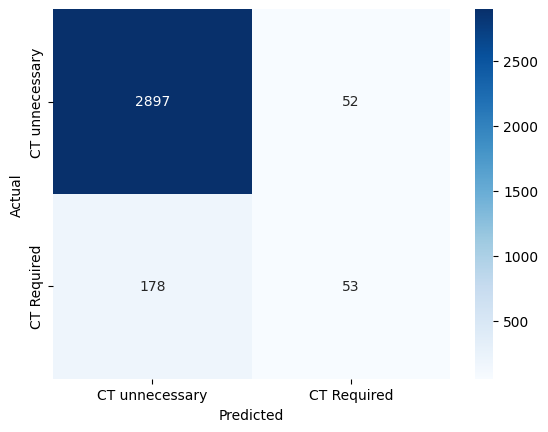

In [167]:
from sklearn.metrics import confusion_matrix
plt.figure()
cm = confusion_matrix(y_test, y_pred)
classes=['CT unnecessary', 'CT Required']
sns.heatmap(cm, annot=True,xticklabels=classes, yticklabels=classes,cmap='Blues',fmt=".0f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [168]:
# prompt: 感度と特異度を算出

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# 混同行列の取得
cm = confusion_matrix(y_test, y_pred)

# 感度（再現率）の計算
sensitivity = recall_score(y_test, y_pred)
print("感度:", sensitivity)

# 特異度の計算
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
print("特異度:", specificity)

感度: 0.22943722943722944
特異度: 0.9823669040352662


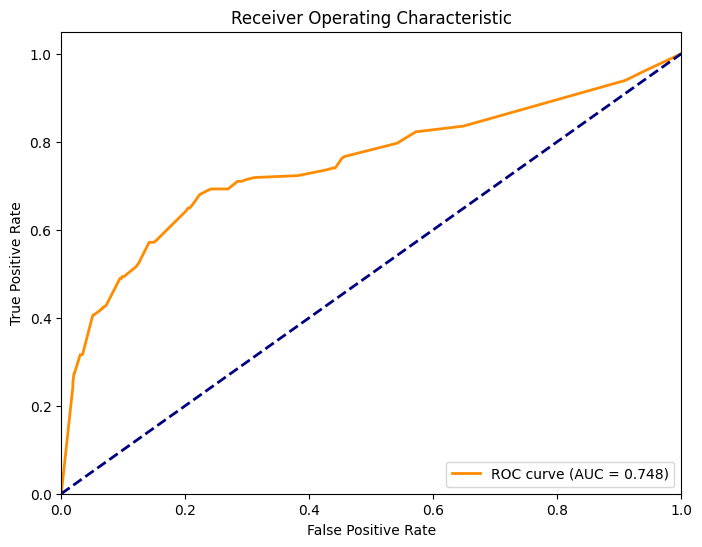

In [169]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# モデルが予測した確率を使用してROC曲線を作成
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# AUCの計算
roc_auc = auc(fpr, tpr)

# ROC曲線のプロット
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()